## GloFAS 
https://www.globalfloods.eu   
https://www.globalfloods.eu/general-information/data-and-services/  

In [87]:
# common import
from datetime import date
import requests, wget
import os, sys,json,csv
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas
# parse HTML to extrac table data
import lxml.html as lh
from IPython.display import Image, HTML
import ipywidgets as wdg
# parse HTML to extrac table data
import lxml.html as lh

### WMS Service  
http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?  
http://www.globalfloods.eu/static/downloads/GloFAS-WMS-T_usermanual.pdf   

In [88]:
# import leaflet
from ipyleaflet import Map,WMSLayer,basemaps,WidgetControl,GeoJSON,Rectangle
# import owslib
from owslib.wms import WebMapService

In [89]:
# load basic information of WMS service
wms_url = 'http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?'
wms = WebMapService(wms_url)
print(wms.identification.title)
print([operation.name for operation in wms.operations])
layers=list(wms.contents)
print(layers)

GLOFAS OWS
['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'DescribeLayer', 'GetLegendGraphic', 'GetStyles']
['GLOFAS_OWS', 'Static', 'date', 'FloodHazard100y', 'MajorRiverBasins', 'GlofasLakesReservoirs', 'GlofasReservoirImpact', 'UpstreamArea', 'MajorRivers1', 'MajorRivers2', 'MajorRivers3', 'MajorRivers4', 'MajorRivers5', 'MajorRivers6', 'AdministrativeRegions', 'ErrorMessage', 'Hydrological', 'RPG_U', 'RPGM', 'RPGH', 'RPGS', 'sumALHEGE', 'sumALEEGE', 'RPG80', 'rivermap_4mon', 'areamap_4mon', 'sumAL41EGE', 'sumAL42EGE', 'sumAL43EGE', 'Meteorological', 'EGE_probRgt300', 'EGE_probRgt150', 'EGE_probRgt50', 'AccRainEGE', 'RainAnimation', 'Flood risk', 'RapidImpactAssessment', 'RapidFloodMapping']


### Reporting Points   
Reporting points where more forecast information is available. Purple/red/yellow points denote a forecasted probability to exceed a 20 year (purple)/ 5 year (red)/ 2 year (yellow) return period of > 20 %. Numbers denote the percentage of ensemble members exceeding the specific return period. Shape denotes rising (upward triangle), decreasing (downward triangle), or stagnant (circle) trend of the ensemble mean discharge within the forecast horizon. The gray squares represent reporting points with no forecast exceeding 2 year return levels. 

In [90]:
# info on RPG_U
layer = "RPG_U"
print(wms[layer].title)
print(wms[layer].boundingBox)
print(wms[layer].boundingBoxWGS84)
print(wms[layer].styles)

Reporting Points
(-20037500.0, -20049000.0, 20037500.0, 20049000.0, 'EPSG:3857')
(-180.0, -85.06, 180.0, 85.06)
{'default': {'title': 'default', 'legend': 'http://globalfloods-ows.ecmwf.int/glofas-ows/?version=1.1.1&service=WMS&request=GetLegendGraphic&layer=RPG_U&format=image/png&STYLE=default'}}


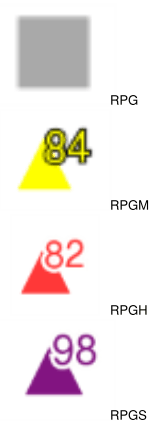

In [91]:
# load legend
legend_url = wms[layer].styles['default']['legend']
legend_image=Image(legend_url,format='png',height=100)
display(legend_image)

In [92]:
# select a testing aqid = 2813
# use geopandas
watersheds_gdb = 'WRIWatersheds.gdb'
# use new watershed data
watersheds_gdb = 'AQID_Watwershed_Jan2020/AQID_Watwershed_Jan2020.shp'
watersheds = geopandas.read_file(watersheds_gdb)
watersheds.set_index("aqid",inplace=True)

In [93]:
test_aqid = 2813 # Australia 2020-02-03
#test_aqid = 2531 # Africa 2020-02-06
#test_aqid = 2308 # Africa easy for testing
# get the image 
x1,y1,x2,y2 = watersheds.loc[[test_aqid],'geometry'].total_bounds
wms_img = wms.getmap(layers=[layer], styles=["default"], srs='EPSG:4326',bbox=[x1,y1,x2,y2],size=(400, 300),format='image/png', transparent=True)

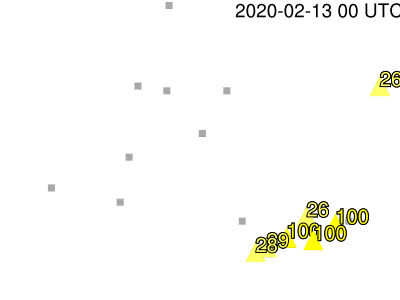

In [94]:
# date: 2020-02-03
Image(wms_img.read())

In [95]:
# example watersheds on leaflet map
test_json = json.loads(geopandas.GeoSeries([watersheds.loc[test_aqid,'geometry']]).to_json())

# Reporting Points: EPSG 3857
wms_layer = 'RPG_U'
m = Map(center=((y1+y2)/2,(x1+x2)/2), zoom=5,basemap=basemaps.Esri.WorldTopoMap)
wms1 = WMSLayer(
    url=wms_url,
    layers=wms_layer,
    transparent=True,
    format="image/png",
    version="1.3.0",
)
m.add_layer(wms1)
poly_json = GeoJSON(data=test_json['features'][0])
m.add_layer(poly_json)
m

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

In [96]:
# work wms getfratureinfo example
wms_paras = {
    'SERVICE':'WMS',
    'REQUEST':'GetFeatureInfo',
    'FORMAT':'image/png',
    'VERSION':'1.3.0',
    'LAYERS':'RPG_U',
    'WIDTH':1020,
    'HEIGHT':678,
    'CRS':'EPSG:3857',
    'BBOX':'-13094904.603227489,2941622.234325256,-8105095.39677251,6258377.765674742',
    'INFO_FORMAT':'text/html',
    'QUERY_LAYERS':'RPG_U',
    'TRANSPARENT':True,
    'TIME':None,
    'I':456,
    'J':227
}
resp = requests.get(wms_url, params=wms_paras)

In [97]:
HTML(resp.text)

In [98]:
# nore feature example
wms_paras['I']=100
wms_paras['J']=100
resp1 = requests.get(wms_url, params=wms_paras)
resp1.text

'No feature selected'

In [99]:
#Store the contents of the website under doc
doc = lh.fromstring(resp.text)

In [100]:
#Check the length of the first 12 rows
tr_elements = doc.xpath('//tr')#Create empty list
col=[]
i=0#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d:"%s"' % (i,name))
    col.append((name,[]))

1:"Country"
2:"Basin"
3:"Station"
4:"Lon"
5:"Lat"
6:"Upstream area (LDD)"
7:"Upstream area (Provider)"


In [101]:
table_content={}
line1 = [t.text_content() for t in tr_elements[0]]
line2 = [t.text_content() for t in tr_elements[1]]
line3 = [t.text_content() for t in tr_elements[2]]
line4 = [t.text_content() for t in tr_elements[3]]
table_content = {line1[i]: line2[i] for i in range(len(line1))} 
table_content.update({line3[i]: line4[i] for i in range(len(line3))})
print(table_content)

{'Country': '0', 'Basin': 'Dynamic Point', 'Station': '0', 'Lon': '-97.45', 'Lat': '41.95', 'Upstream area (LDD)': '8,100', 'Upstream area (Provider)': '0', 'Forecast Date': '2020-02-13 00:00', 'Point No.': '2394', 'max. EPS > threshold [%]': '100/100/0', 'Alert level': '2', 'Probability tendency': '', 'Peak forecasted in': '< 3 days'}


In [102]:
# infromatation extracted
#GloFAS_20yr GloFAS_5yr GloFAS_2yr GloFAS_AlertLevel GloFAS_PeakForecasted
GloFAS_2yr, GloFAS_5yr,GloFAS_20yr = map(float,table_content['max. EPS > threshold [%]'].split('/'))
print(GloFAS_2yr, GloFAS_5yr,GloFAS_20yr)

100.0 100.0 0.0


In [103]:
# turn info extrac as function
def info_extractor(htmlstr):
    #Store the contents of the website under doc
    doc = lh.fromstring(htmlstr)
    #Check the length of the first 12 rows
    tr_elements = doc.xpath('//tr')#Create empty list
    table_content={}
    line1 = [t.text_content() for t in tr_elements[0]]
    line2 = [t.text_content() for t in tr_elements[1]]
    line3 = [t.text_content() for t in tr_elements[2]]
    line4 = [t.text_content() for t in tr_elements[3]]
    table_content = {line1[i]: line2[i] for i in range(len(line1))} 
    table_content.update({line3[i]: line4[i] for i in range(len(line3))})
    #GloFAS_20yr GloFAS_5yr GloFAS_2yr GloFAS_AlertLevel GloFAS_PeakForecasted
    GloFAS_2yr, GloFAS_5yr,GloFAS_20yr = map(float,table_content['max. EPS > threshold [%]'].split('/'))
    table_content.update({'GloFAS_2yr':GloFAS_2yr,'GloFAS_5yr':GloFAS_5yr,'GloFAS_20yr':GloFAS_20yr})
    return table_content

In [104]:
# initial work on auto-extrac, no good, skip now
# will work on it more with image processing later
# wms_paras['REQUEST']='GetMap'
# resp = requests.get(wms_url, params=wms_paras)
# a=plt.imread(resp.url)
# a.shape
# #unique color in image
# #np.unique(a.reshape(-1, a.shape[2]), axis=0)
# # find no tranparent point
# y,x = a[:,:,3].nonzero() # get the nonzero alpha coordinates
# count = 0
# for i in range(len(x)):
#     r,g,b,c = a[y[i],x[i]]
#     if r<=0.2 and g<=0.2 and b<=0.2:
#         continue
#     if r==b and g==b:
#         continue
#     if r>=0.8 and g>=0.8 and b>=0.8:
#         continue
#     count += 1
    
# print(count)

In [105]:
# work on Africa flood
# set up a research area
rectangle = Rectangle(bounds=((-2.0,23), (-27.0,42.0)))
m.add_layer(rectangle)
m

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

In [106]:
# seems transformation is not right
# old pyproj version 1.9.6
#(-2.0,23), (-27.0,42.0)
# from pyproj import Proj, transform
# p1 = Proj(init='epsg:4326')
# p2 = Proj(init='epsg:3857')
# lon1, lat1 = p1(23,-2.0)
# # transform this point to projection 2 coordinates.
# x1, y1 = transform(p1,p2,lon1,lat1)
# lon2, lat2 = p1(42,-27.0)
# # transform this point to projection 2 coordinates.
# x2, y2 = transform(p1,p2,lon2,lat2)
# bbox = [min(x1,x2),min(y1,y2),max(x1,x2),max(y1,y2)]
# bbox_str = ",".join(map(str,bbox))
# print(bbox_str)

In [107]:
# try projection with geopandas
from shapely.geometry import Point
s = geopandas.GeoSeries([Point(23, -2.0), Point(42, -27)])
s.crs = {'init' :'epsg:4326'}
s_prj=s.to_crs({'init': 'epsg:3857'})
x1,y1,x2,y2 = s_prj[0].x,s_prj[0].y,s_prj[1].x,s_prj[1].y
bbox = [min(x1,x2),min(y1,y2),max(x1,x2),max(y1,y2)]
bbox_str = ",".join(map(str,bbox))
print(bbox_str)

2560348.2882452914,-3123471.7491045785,4675418.613317491,-222684.20850554478


http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?SERVICE=WMS&REQUEST=GetMap&FORMAT=image%2Fpng&VERSION=1.3.0&LAYERS=RPG_U&WIDTH=600&HEIGHT=800&CRS=EPSG%3A3857&BBOX=2560348.2882452914%2C-3123471.7491045785%2C4675418.613317491%2C-222684.20850554478&INFO_FORMAT=text%2Fhtml&QUERY_LAYERS=RPG_U&TRANSPARENT=True&I=100&J=100


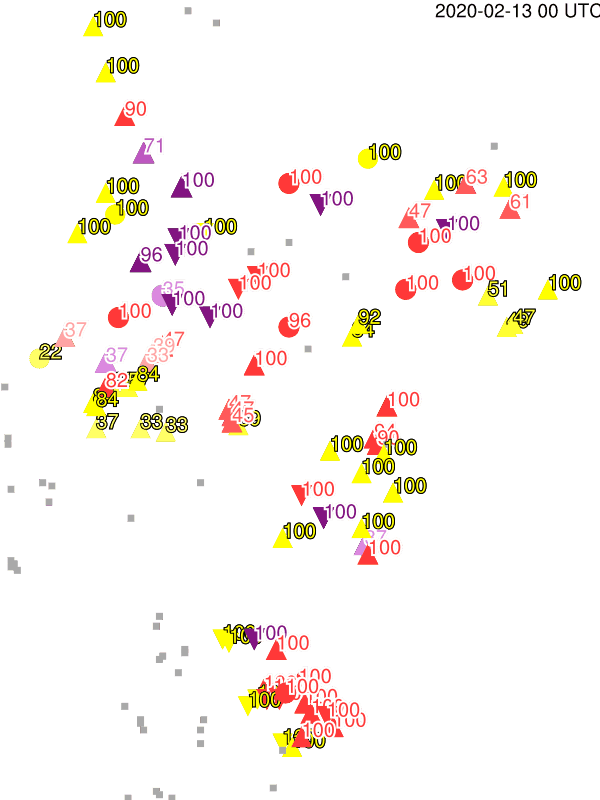

In [108]:
wms_paras['REQUEST']='GetMap'
# wms_paras['CRS']='EPSG:4326'
# wms_paras['BBOX'] = "-27,23,-2,42"
# resp = requests.get(wms_url, params=wms_paras)
# print(resp.url)
# Image(resp.content)
# test EPSG:3857
wms_paras['CRS']='EPSG:3857'
wms_paras['BBOX'] = '2560348.29,-3123471.75,4675418.61,-222684.21'
wms_paras['BBOX'] = bbox_str
wms_paras['WIDTH']=600
wms_paras['HEIGHT']=800
resp = requests.get(wms_url, params=wms_paras)
print(resp.url)
Image(resp.content)

Textarea(value='', description='event:', placeholder='')

<IPython.core.display.Javascript object>


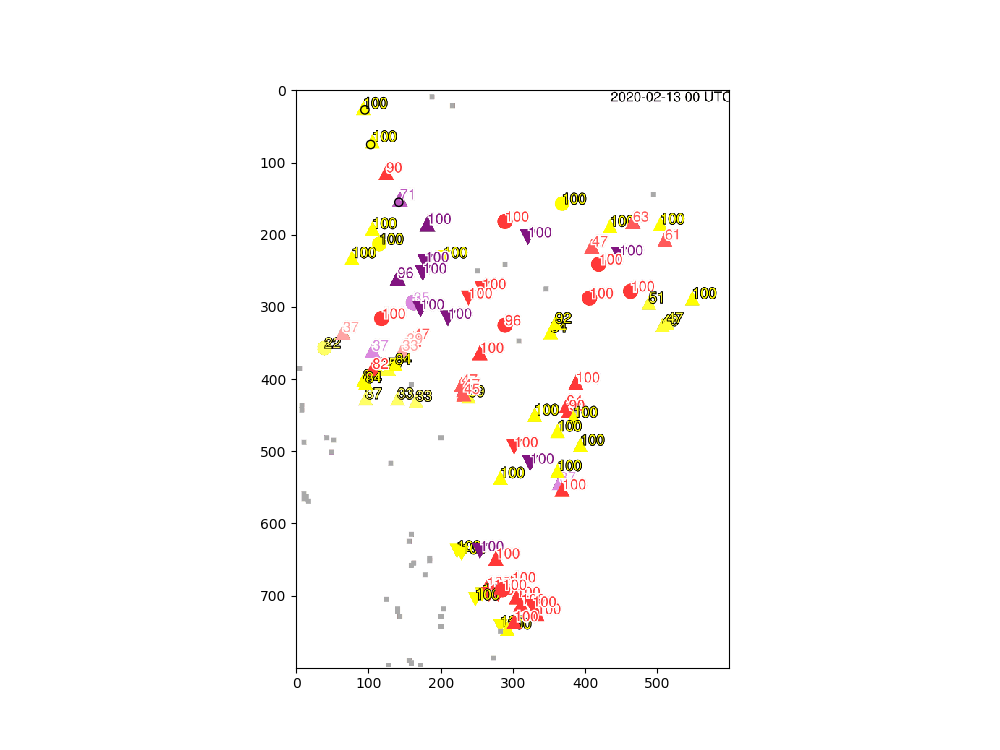

In [109]:
# dynamic collector
collector = []
i = 0
wms_paras['REQUEST']='GetFeatureInfo'
def onclick(event):
    global i, collector
    wms_p = wms_paras
    para_I = int(event.xdata)
    para_J = int(event.ydata)
    wms_p["I"]=para_I
    wms_p["J"]=para_J
    resp_click = requests.get(wms_url, params=wms_p)
    info_str = resp_click.text
    if (info_str != "No feature selected"):
        info = info_extractor(info_str)
        info.update({"url":resp_click.url})
        collector.append(info)
        i += 1
        txt.value = "hit on " + str(para_I) + "," + str(para_J) + " total: " + str(i)
        plt.scatter([para_I], [para_J],facecolors='none', edgecolors='black')

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)
%matplotlib notebook
a=plt.imread(resp.url)
fig = plt.figure(figsize=(800/80,600/80))
fig.canvas.mpl_connect('button_press_event', onclick)
plt.imshow(a)
plt.show()

In [81]:
# write the data to CSV file
# csv_columns = list(collector[0].keys())
# if len(collector) > 0:
#     with open("picker.csv","a") as f:
#         writer = csv.DictWriter(f, fieldnames=csv_columns)
#         writer.writeheader()
#         for data in collector:
#             writer.writerow(data)
    

In [110]:
collector

[{'Country': '0',
  'Basin': 'Dynamic Point',
  'Station': '0',
  'Lon': '26.35',
  'Lat': '-4.35',
  'Upstream area (LDD)': '762,800',
  'Upstream area (Provider)': '0',
  'Forecast Date': '2020-02-13 00:00',
  'Point No.': '2427',
  'max. EPS > threshold [%]': '100/45/0',
  'Alert level': '1',
  'Probability tendency': '',
  'Peak forecasted in': '> 10 days',
  'GloFAS_2yr': 100.0,
  'GloFAS_5yr': 45.0,
  'GloFAS_20yr': 0.0,
  'url': 'http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?SERVICE=WMS&REQUEST=GetFeatureInfo&FORMAT=image%2Fpng&VERSION=1.3.0&LAYERS=RPG_U&WIDTH=600&HEIGHT=800&CRS=EPSG%3A3857&BBOX=2560348.2882452914%2C-3123471.7491045785%2C4675418.613317491%2C-222684.20850554478&INFO_FORMAT=text%2Fhtml&QUERY_LAYERS=RPG_U&TRANSPARENT=True&I=103&J=75'},
 {'Country': '0',
  'Basin': 'Dynamic Point',
  'Station': '0',
  'Lon': '25.95',
  'Lat': '-2.85',
  'Upstream area (LDD)': '795,700',
  'Upstream area (Provider)': '0',
  'Forecast Date': '2020-02-13 00:00',
  'Point No.': '2

### Web Map Service Time (WMS-T)  
A WMS server can provide support to temporal requests (WMS-T). This is done by providing a TIME parameter with a time value in the request.

In [112]:
# Limpopo, Mogalakwena River At Glen Alpine, I=182, J=670
wms_paras1=wms_paras
wms_paras1["I"]=182
wms_paras1["J"]=670
# test time parameter: yesterday, one week before, and one year before
time_list = ['2020-02-13T00:00:00','2020-02-07T00:00:00','2019-02-14T00:00:00']
for time_para in time_list:
    wms_paras1['TIME'] = time_para
    resp_t = requests.get(wms_url, params=wms_paras1)
    info_str_t = resp_t.text
    if (info_str_t != "No feature selected"):
        info_t = info_extractor(info_str_t)
        print(time_para)
        print(info_t)


2020-02-13T00:00:00
{'Country': 'South Africa', 'Basin': 'Limpopo', 'Station': 'Mogalakwena River At Glen Alpine', 'Lon': '28.65', 'Lat': '-23.25', 'Upstream area (LDD)': '11,000', 'Upstream area (Provider)': '11,300', 'Forecast Date': '2020-02-13 00:00', 'Point No.': '2102', 'max. EPS > threshold [%]': '2/0/0', 'Alert level': '0', 'Probability tendency': '', 'Peak forecasted in': '< 3 days', 'GloFAS_2yr': 2.0, 'GloFAS_5yr': 0.0, 'GloFAS_20yr': 0.0}
2020-02-07T00:00:00
{'Country': 'South Africa', 'Basin': 'Limpopo', 'Station': 'Mogalakwena River At Glen Alpine', 'Lon': '28.65', 'Lat': '-23.25', 'Upstream area (LDD)': '11,000', 'Upstream area (Provider)': '11,300', 'Forecast Date': '2020-02-07 00:00', 'Point No.': '2102', 'max. EPS > threshold [%]': '16/6/2', 'Alert level': '0', 'Probability tendency': '', 'Peak forecasted in': '> 10 days', 'GloFAS_2yr': 16.0, 'GloFAS_5yr': 6.0, 'GloFAS_20yr': 2.0}
2019-02-14T00:00:00
{'Country': 'South Africa', 'Basin': 'Limpopo', 'Station': 'Mogalakwe